# Final Project: Classification Driving Behaviours

- Context

Driver behavior is one of the most important aspects in the design, development, 

and application of Advanced Driving Assistance Systems (ADAS) and Intelligent Transportation Systems (ITS),

which can be affected by many factors. If you are able to measure the driving style of your staff,

there is a lot of actions you can take in order to improve fleet safety, global road safety as well as fuel efficiency and emissions.


- Content

Dataset for modeling risky driver behaviors based on accelerometer (X,Y,Z axis in meters per second squared (m/s2)) 

and gyroscope (X,Y, Z axis in degrees per second (°/s) ) data.

- Sampling Rate: Average 2 samples (rows) per second
- Cars: Ford Fiesta 1.4, Ford Fiesta 1.25, Hyundai i20
- Drivers: 3 different drivers with the ages of 27, 28 and 37

Driver Behaviors:
- 1.Sudden Acceleration (Class Label: 1)
- 2.Sudden Right Turn (Class Label: 2)
- 3.Sudden Left Turn (Class Label: 3)
- 4.Sudden Break (Class Label: 4)

------------
- Best Window Size: 14 seconds
- Sensor: MPU6050
- Device: Raspberry Pi 3 Model B

## Import Dependencies

In [1]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from scipy import interp

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import LabelBinarizer

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

## Read Data

In [2]:
df = pd.read_csv("drivers.csv")

In [3]:
df.head()

,Target,AccMeanX,AccMeanY,AccMeanZ,AccCovX,AccCovY,AccCovZ,AccSkewX,AccSkewY,AccSkewZ,...,GyroMaxZ,GyroVarX,GyroVarY,GyroVarZ,GyroMedianX,GyroMedianY,GyroMedianZ,GyroStdX,GyroStdY,GyroStdZ
0,1,0.285339,-0.138611,-0.957764,0.022150,0.003975,0.001926,0.867594,-1.305868,-0.507254,...,0.832061,0.761120,0.184372,0.262859,-0.286260,4.251908,0.706107,0.872422,0.429385,0.512697
1,1,0.313477,-0.161670,-0.956250,0.020571,0.005640,0.001456,0.002474,-0.395088,-0.677572,...,0.832061,3.061080,0.585991,0.270340,0.335878,3.969466,0.587786,1.749594,0.765501,0.519942
2,1,0.325195,-0.158325,-0.950155,0.017281,0.004579,0.001388,-0.354212,-0.603657,-0.984635,...,0.832061,3.137076,0.552431,0.905518,-0.286260,3.832061,0.240458,1.771179,0.743257,0.951587
3,1,0.336565,-0.172468,-0.937640,0.015305,0.005216,0.002253,-0.655653,-0.152454,-0.040530,...,0.832061,2.809524,3.963056,0.893127,0.335878,3.969466,-0.106870,1.676163,1.990743,0.945054
4,1,0.337860,-0.164185,-0.941681,0.013132,0.005020,0.002062,-0.718488,-0.446061,0.250539,...,0.832061,2.667567,3.414394,0.799787,-0.286260,4.038168,-0.179389,1.633269,1.847808,0.894308


"Target" column is our output label. Other columns are independent variables.

In [4]:
df.shape

(1102, 61)

## Variable Decomposition

In [5]:
x = df.iloc[: ,1:]
y = df.iloc[:, 0]

In [6]:
x[0:5]

,AccMeanX,AccMeanY,AccMeanZ,AccCovX,AccCovY,AccCovZ,AccSkewX,AccSkewY,AccSkewZ,AccKurtX,...,GyroMaxZ,GyroVarX,GyroVarY,GyroVarZ,GyroMedianX,GyroMedianY,GyroMedianZ,GyroStdX,GyroStdY,GyroStdZ
0,0.285339,-0.138611,-0.957764,0.022150,0.003975,0.001926,0.867594,-1.305868,-0.507254,-1.164806,...,0.832061,0.761120,0.184372,0.262859,-0.286260,4.251908,0.706107,0.872422,0.429385,0.512697
1,0.313477,-0.161670,-0.956250,0.020571,0.005640,0.001456,0.002474,-0.395088,-0.677572,-2.649441,...,0.832061,3.061080,0.585991,0.270340,0.335878,3.969466,0.587786,1.749594,0.765501,0.519942
2,0.325195,-0.158325,-0.950155,0.017281,0.004579,0.001388,-0.354212,-0.603657,-0.984635,-1.819232,...,0.832061,3.137076,0.552431,0.905518,-0.286260,3.832061,0.240458,1.771179,0.743257,0.951587
3,0.336565,-0.172468,-0.937640,0.015305,0.005216,0.002253,-0.655653,-0.152454,-0.040530,-1.214712,...,0.832061,2.809524,3.963056,0.893127,0.335878,3.969466,-0.106870,1.676163,1.990743,0.945054
4,0.337860,-0.164185,-0.941681,0.013132,0.005020,0.002062,-0.718488,-0.446061,0.250539,-0.666622,...,0.832061,2.667567,3.414394,0.799787,-0.286260,4.038168,-0.179389,1.633269,1.847808,0.894308


In [7]:
y[0:5]

0    1
1    1
2    1
3    1
4    1
Name: Target, dtype: int64

- x: independent variables
- y: dependent variable

## Train-Test Split

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

## Support Vector Machines Model

In [9]:
svc = SVC()
svc_model = svc.fit(x_train, y_train)

In [10]:
y_pred = svc_model.predict(x_test)
accuracy_score(y_test, y_pred)

0.8099547511312217

In [11]:
cross_val_score(svc_model, x_test, y_test, cv=3).mean()

0.7195483154387263

In [12]:
cross_val_score(svc_model, x_test, y_test, cv=5).mean()

0.7194949494949495

In [13]:
cross_val_score(svc_model, x_test, y_test, cv=10).mean()

0.7197628458498023

## SVC Model Tuning

In [14]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}]

In [15]:
grid_search = GridSearchCV(svc_model,
                           param_grid,
                           cv=10).fit(x_train, y_train)

In [16]:
grid_search.best_params_

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

In [17]:
svc = SVC(C=100, gamma=0.001, kernel='rbf')
svc_tuned = svc.fit(x_train, y_train)

In [18]:
y_pred_tuned = svc_tuned.predict(x_test)
accuracy_score(y_test, y_pred_tuned)

0.9909502262443439

## Performance Metrics

Sensitivity, specificity, Precision, F1 score and AUC

### Confusion Matrix

#### Non-Tuned Model

[[36  0  0 22]
 [ 0 54  0  0]
 [ 8  0 47  6]
 [ 6  0  0 42]]


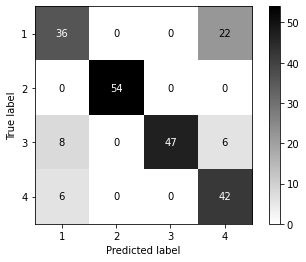

In [19]:
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(svc_model, x_test, y_test, cmap='gray_r');

#### Tuned Model

[[58  0  0  0]
 [ 0 54  0  0]
 [ 1  0 59  1]
 [ 0  0  0 48]]


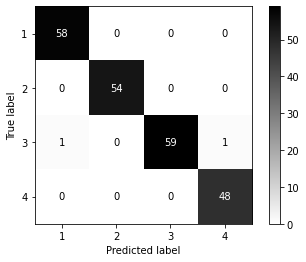

In [20]:
print(confusion_matrix(y_test, y_pred_tuned))
plot_confusion_matrix(svc_tuned, x_test, y_test, cmap='gray_r');

In [21]:
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           1       0.98      1.00      0.99        58
           2       1.00      1.00      1.00        54
           3       1.00      0.97      0.98        61
           4       0.98      1.00      0.99        48

    accuracy                           0.99       221
   macro avg       0.99      0.99      0.99       221
weighted avg       0.99      0.99      0.99       221



### Scorings

In [22]:
def matrix_metrix(y_test,y_pred,beta):
   CM = confusion_matrix(y_test,y_pred)
   TN = CM[0][0]
   FN = CM[1][0] 
   TP = CM[1][1]
   FP = CM[0][1]

   Specificity= round( TN / (TN+FP),4 ) 
   Sensitivity= round( TP / (TP+FN),4 ) 

   Prevalence = round( (TP+FP) / (TN+FN+TP+FP),2)
   Accuracy   = round( (TP+TN) / (TN+FN+TP+FP),4)
   Precision  = round( TP / (TP+FP),4 )
   F1         = round ( 2 * ((Precision*Sensitivity)/(Precision+Sensitivity)),4)
   FBeta      = round ( (1+beta**2)*((Precision*Sensitivity)/((beta**2 * Precision)+ Sensitivity)) ,4)

   mat_met = pd.DataFrame({
                'Metric':['TP','TN','FP','FN','Specificity','Sensitivity','Prevalence',
                          'Accuracy','Precision','F1','FBeta'],
                'Value':[TP,TN,FP,FN,Specificity,Sensitivity,Prevalence,Accuracy,Precision,F1,FBeta]})

   return (mat_met)

Specificity = Selectivity,

Sensitivity = Recall = Power

In [23]:
beta = 0.4
mat_met = matrix_metrix(y_test,y_pred_tuned,beta)
print (mat_met)

         Metric  Value
0            TP  54.00
1            TN  58.00
2            FP   0.00
3            FN   0.00
4   Specificity   1.00
5   Sensitivity   1.00
6    Prevalence   0.48
7      Accuracy   1.00
8     Precision   1.00
9            F1   1.00
10        FBeta   1.00


### ROC Implementation For Sudden Acceleration

In [24]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(221, 4)

In [25]:
label_binarizer = LabelBinarizer().fit(y_test)
y_tuned = label_binarizer.transform(y_pred_tuned)

In [26]:
y_sAcc = y_tuned[:, 0]

AUC: 0.997


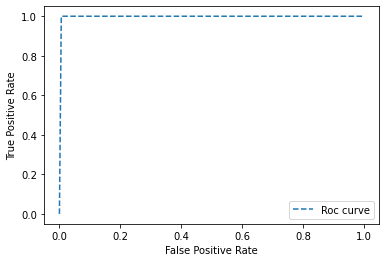

In [27]:
fpr, tpr, thresholds = roc_curve(y_onehot_test[:,0], y_sAcc)
auc = roc_auc_score(y_onehot_test[:,0], y_sAcc)
print('AUC: %.3f' % auc)
plt.plot(fpr, tpr, linestyle='--', label='Roc curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Precision-Recall Implementation For Sudden Acceleration

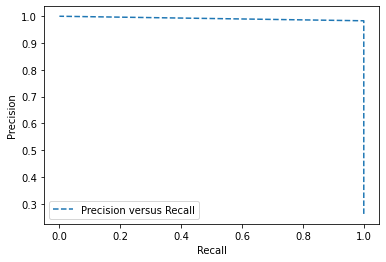

In [28]:
#Precision-recall implementation
precision, recall, thresholds = precision_recall_curve(y_onehot_test[:,0], y_sAcc)
plt.plot(recall, precision, linestyle='--', label='Precision versus Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

### ROC Implementation For Sudden Brake

In [29]:
y_sBrake = y_tuned[:, 3]

AUC: 0.997


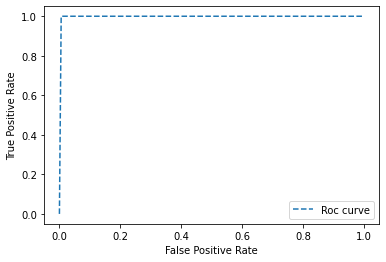

In [30]:
fpr, tpr, thresholds = roc_curve(y_onehot_test[:,3], y_sBrake)
auc = roc_auc_score(y_onehot_test[:,3], y_sBrake)
print('AUC: %.3f' % auc)
plt.plot(fpr, tpr, linestyle='--', label='Roc curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Precision-Recall Implementation For Sudden Brake

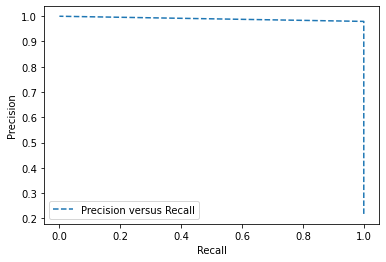

In [31]:
#Precision-recall implementation
precision, recall, thresholds = precision_recall_curve(y_onehot_test[:,3], y_sBrake)
plt.plot(recall, precision, linestyle='--', label='Precision versus Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()